# Model-Based Decision Making

This notebook contains the final code of Group 22's assignment for the course EPA1361.

In this code, we explore scenarios for the studied policy problem (flood risk management for the IJssel river) using open exploration, and then apply directed search (MORDM) to find optimal results.

## Table of contents
1. [Exploration](#Exploration)
    1. [Problem formulation 3](#Problem-formulation-3)
    2. [Problem formulation 4](#Problem-formulation-4)
2. [Optimization](#Optimization)

_The items in this table of contents may only be clickable in the browser version of Jupyter Notebook._

In [41]:
# Settings
save_exploration_data = False
save_figures = True

In [42]:
# All needed imports
## Python packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from pathlib import Path
## EMA workbench!
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    MultiprocessingEvaluator, save_results
)
## IJssel dike model
from problem_formulation import get_model_for_problem_formulation

In [43]:
# Set up
## Set up logging
ema_logging.log_to_stderr(ema_logging.INFO)
## Set up folders
if save_exploration_data:
    exploration_data_path = "./MBDM_Final_Data/Exploration_Data"
    Path(exploration_data_path).mkdir(parents=True, exist_ok=True)
if save_figures:
    figures_path = "./MBDM_Final_Data/Figures"
    Path(figures_path).mkdir(parents=True, exist_ok=True)

## Exploration

We will explore five policies:

1. a baseline (no actions taken)
2. implementing room for the river (RfR) everywhere
3. heightening all dikes by 50cm in every timestep
4. RfR only near Natura 2000 areas (dike rings 1 and 2), dike heightening of 50 cm in timestep 3 in the other dike rings
5. the final policy of the MBDM debate, including RfR in dike rings 1 and 4, and moderate dike heightening in each dike ring

In [44]:
# In the two problem formulations we want to explore, the levers are the same.
# This function will return the policy list, based on the default values of a problem formulation.

def get_policies(do_nothing_dict):
    return [
        Policy("Baseline", **do_nothing_dict),
        Policy("RfR everywhere",
            **dict(
                do_nothing_dict,
                **{'0_RfR 0':1,
                    '0_RfR 1':1,
                    '0_RfR 2':1,
                    '1_RfR 0':1,
                    '1_RfR 1':1,
                    '1_RfR 2':1,
                    '2_RfR 0':1,
                    '2_RfR 1':1,
                    '2_RfR 2':1,
                    '3_RfR 0':1,
                    '3_RfR 1':1,
                    '3_RfR 2':1,
                    '4_RfR 0':1,
                    '4_RfR 1':1,
                    '4_RfR 2':1
                }
            )
        ),
        Policy("Dike heightening everywhere",
            **dict(
                do_nothing_dict,
                **{'A.1_DikeIncrease 0':5,
                    'A.1_DikeIncrease 1':5,
                    'A.1_DikeIncrease 2':5,
                    'A.2_DikeIncrease 0':5,
                    'A.2_DikeIncrease 1':5,
                    'A.2_DikeIncrease 2':5,
                    'A.3_DikeIncrease 0':5,
                    'A.3_DikeIncrease 1':5,
                    'A.3_DikeIncrease 2':5,
                    'A.4_DikeIncrease 0':5,
                    'A.4_DikeIncrease 1':5,
                    'A.4_DikeIncrease 2':5,
                    'A.5_DikeIncrease 0':5,
                    'A.5_DikeIncrease 1':5,
                    'A.5_DikeIncrease 2':5
                }
            )
        ),
        # Dike heightening occurs only in the last timesteps.
        Policy("RfR in Natura 2000 areas",
            **dict(
                do_nothing_dict,
                **{'0_RfR 0':1,
                   '1_RfR 0':1,
                   'A.3_DikeIncrease 0': 0,
                   'A.3_DikeIncrease 1': 0,
                   'A.3_DikeIncrease 2': 5,
                   'A.4_DikeIncrease 0': 0,
                   'A.4_DikeIncrease 1': 0,
                   'A.4_DikeIncrease 2': 5,
                   'A.5_DikeIncrease 0': 0,
                   'A.5_DikeIncrease 1': 0,
                   'A.5_DikeIncrease 2': 5
                }
            )
        ),
        # Policy agreed upon by majority of actors during the debate
        Policy("Final approved policy",
            **dict(
                do_nothing_dict,
                **{'0_RfR 0': 1,
                   'A.1_DikeIncrease 1': 3,
                   'A.2_DikeIncrease 0': 3,
                   'A.3_DikeIncrease 0': 10,
                   '3_RfR 0': 1,
                   'A.4_DikeIncrease 1': 3,
                   'A.5_DikeIncrease 0': 10
                }
            )
        ),
    ]

# The code for the two studied problem formulations could also be simplfied into a loop, but it is convenient to keep them separate if steps or parameters need to be changed for one of the two.

### Problem formulation 3

In [45]:
## Get the model
dike_model, planning_steps = get_model_for_problem_formulation(2)

## Function to get default values for all levers
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

In [46]:
## Define policies to explore
policies = get_policies(get_do_nothing_dict())

In [47]:
# Run the model with the EMA workbench
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 200 scenarios * 5 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:21<00:00, 47.16it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [48]:
# Save exploration results if needed
if save_exploration_data:
    save_results(results, exploration_data_path + '/exploration_PF3_results.tar.gz')

In [49]:
# Separate results into experiments and outcomes, and select policies
experiments, outcomes = results
policies = experiments['policy']

In [50]:
# Convert outcomes into a dataframe to plot
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

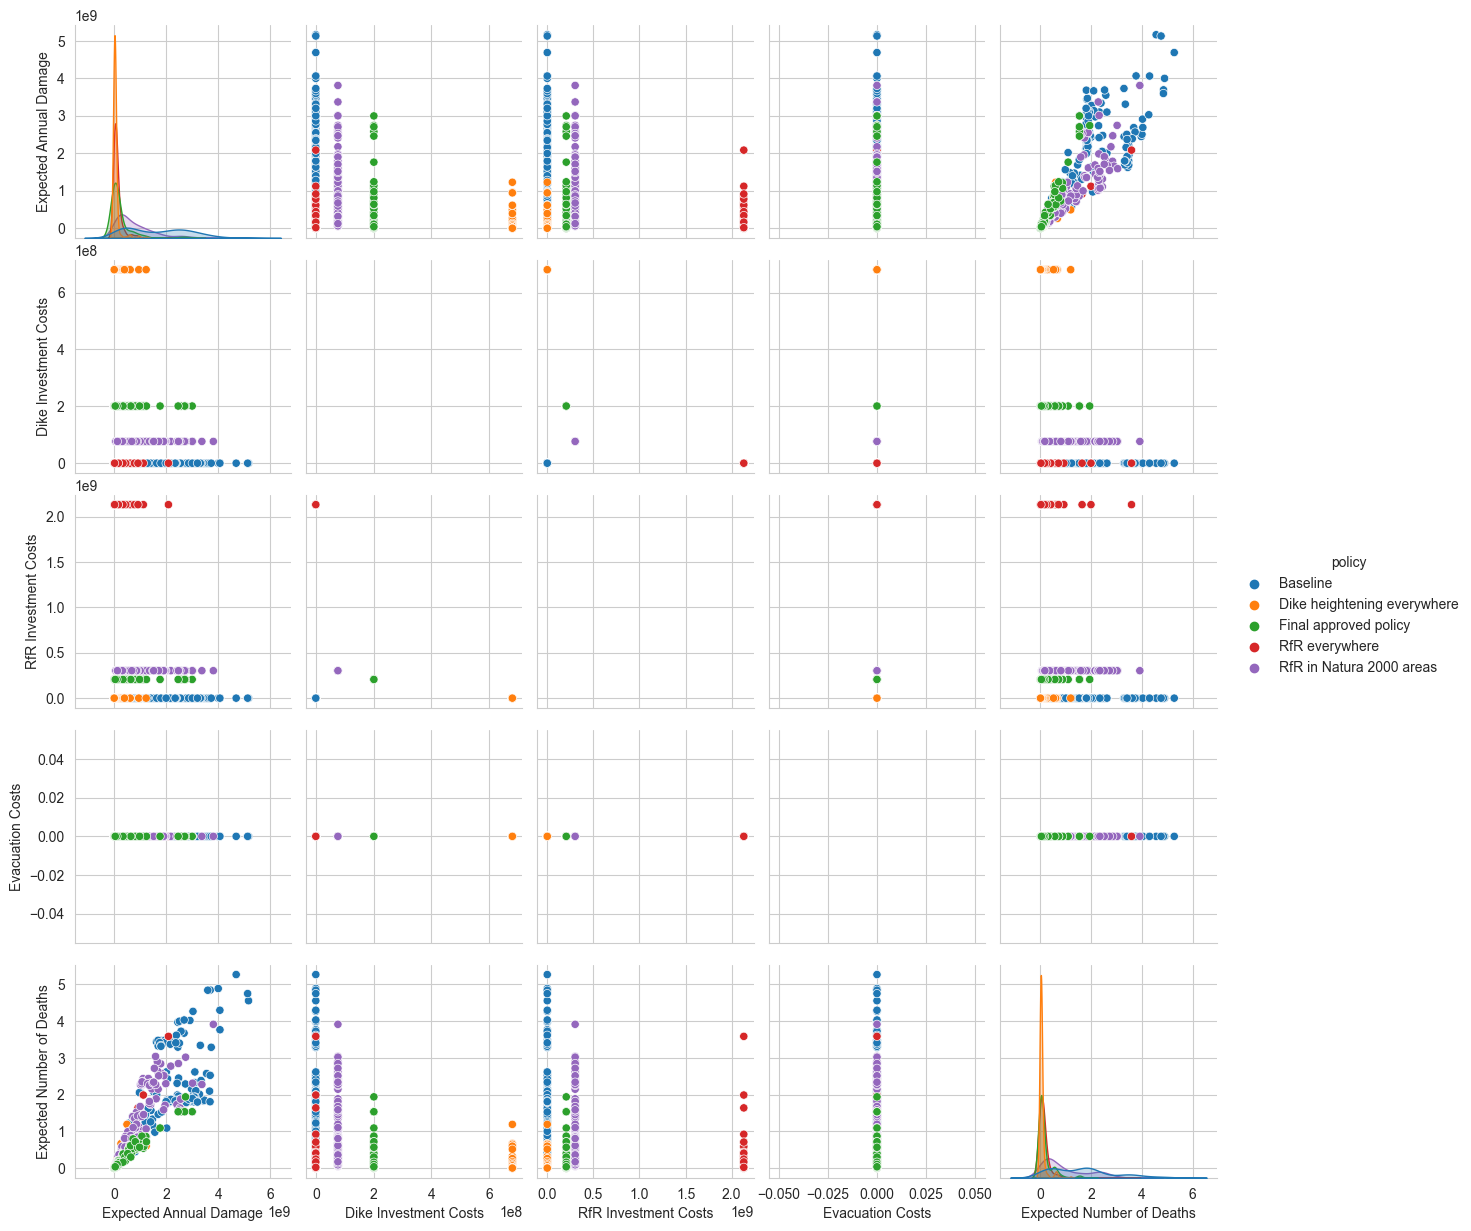

In [51]:
# Plot results
plot = sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
plt.show()

In [52]:
if save_figures:
    plot.figure.savefig(figures_path + "/exploration_PF3_policies.png", dpi=300)

### Problem formulation 4

In [53]:
## Get the model
dike_model, planning_steps = get_model_for_problem_formulation(3)

## Function to get default values for all levers
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

In [54]:
## Define policies to explore
policies = get_policies(get_do_nothing_dict())

In [55]:
# Run the model with the EMA workbench
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 200 scenarios * 5 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:19<00:00, 52.21it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [56]:
# Save exploration results if needed
if save_exploration_data:
    save_results(results, exploration_data_path + '/exploration_PF4_results.tar.gz')

In [57]:
# Separate results into experiments and outcomes, and select policies
experiments, outcomes = results
policies = experiments['policy']

In [58]:
# Convert outcomes into a dataframe to plot
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

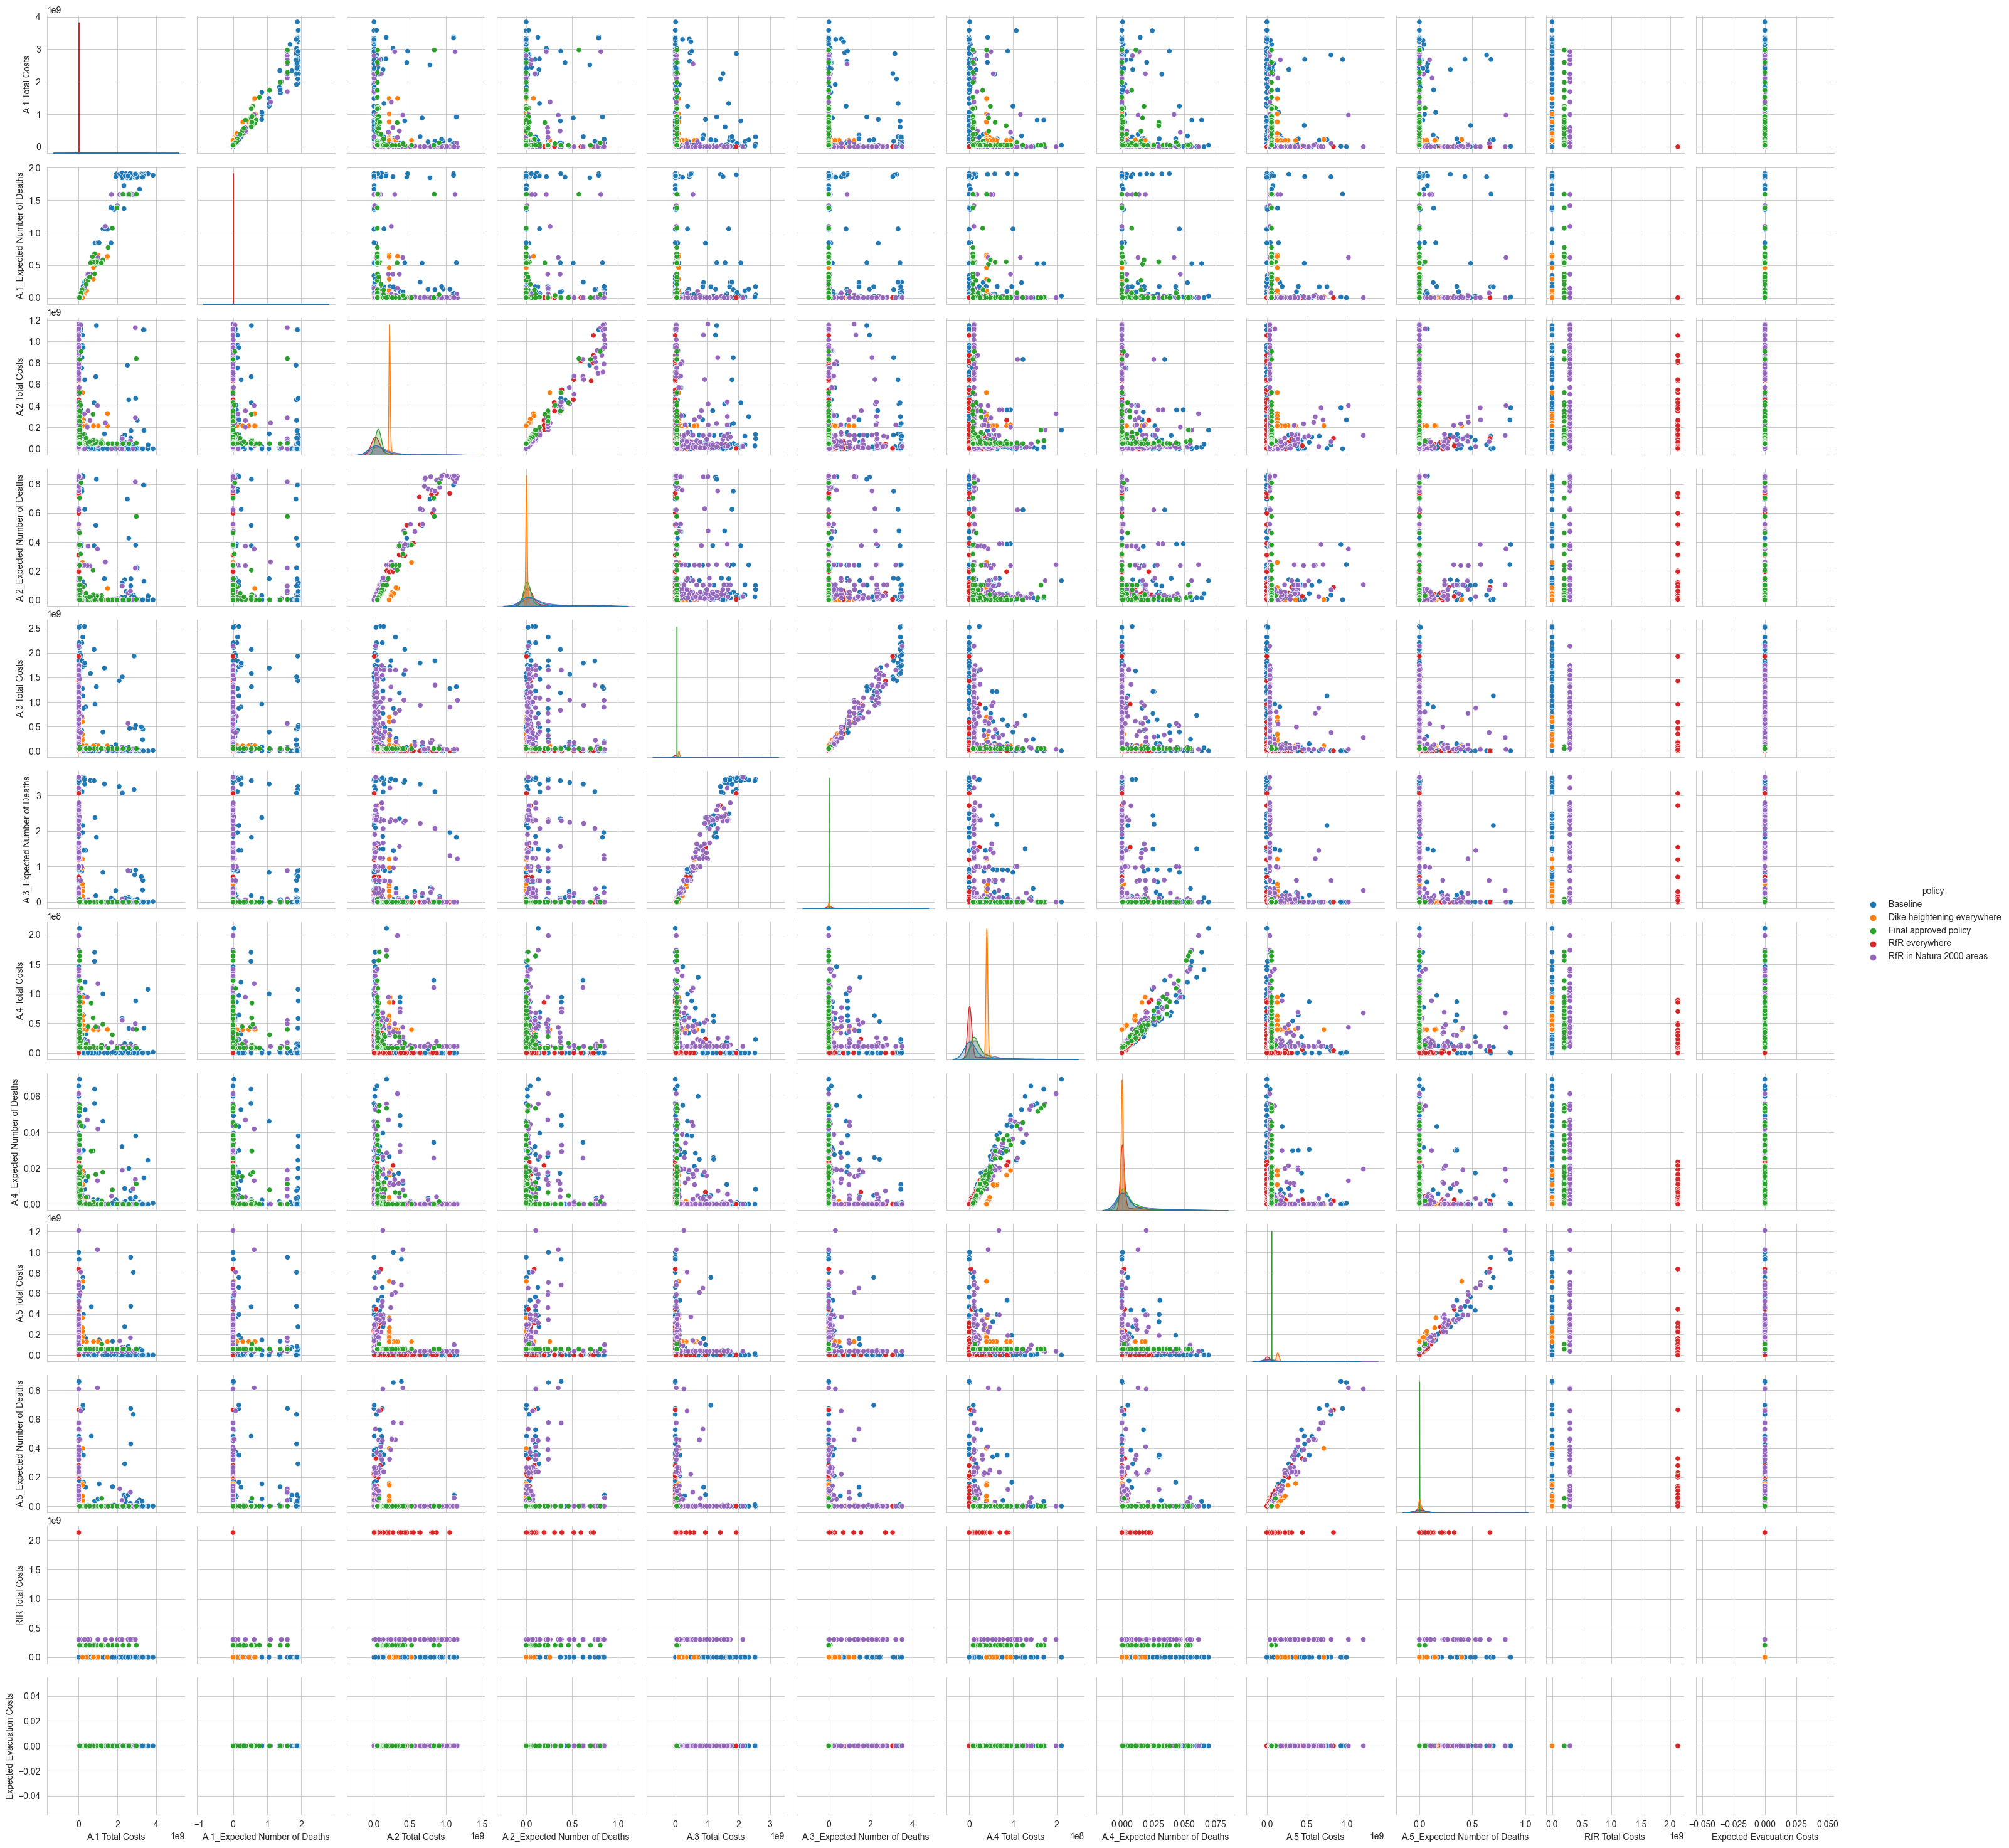

In [59]:
# Plot results
plot = sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
plt.show()

In [60]:
if save_figures:
    plot.figure.savefig(figures_path + "/exploration_PF4_policies.png", dpi=300)

## Optimization